In [27]:
!pip install opencv-python -q
!pip install pillow -q

In [28]:
import numpy as np 
import cv2 
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 
TRACING = True

In [29]:
class Tracing():
    def __call__(self, x):
        if TRACING:
            print(x)
        else:
            pass

tracing = Tracing()

In [30]:
class Depot(Env):
    def __init__(self, n_movers, n_loaders, n_trucks=5):
        super(Depot, self).__init__()

        self.observation_shape = (250, 250, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)

        self.action_space = spaces.MultiDiscrete(np.array([4, 18, 8]))     # 4 actions, 18 pallets, 8 platforms
        self.canvas = np.ones(self.observation_shape)
        self.elements = []
        self.n_movers = n_movers
        self.n_loaders = n_loaders
        self.trucks = [Truck('truck', 225, 15, 37, 25) for _ in range(n_trucks)]
        self.platforms = [Platform(i) for i in range(8)]            # 8 platforms 
        self.pallets = [Pallet(i) for i in range(18)]               # 18 pallets

        self.y_min = 0
        self.x_min = 0
        self.y_max = 250
        self.x_max = 250


    def draw_elements_on_canvas(self):
        self.canvas = np.ones(self.observation_shape) * 255
        coordinates = [
                       [(0, 50), (200, 250)], 
                       [(0, 50), (25, 75)],
                       [(25, 50), (50, 75)],
                       [(50, 50), (75, 75)],
                       [(75, 50), (100, 75)],
                       [(100, 50), (125, 75)],
                       [(125, 50), (150, 75)],
                       [(150, 50), (175, 75)],
                       [(175, 50), (200, 75)],

                       [(0, 100), (50, 125)],
                       [(0, 125), (50, 150)],
                       [(0, 150), (50, 175)],
                       [(0, 175), (50, 200)],
                       [(0, 200), (50, 225)],
                       [(0, 225), (50, 250)],

                       [(75, 100), (125, 125)],
                       [(75, 125), (125, 150)],
                       [(75, 150), (125, 175)],
                       [(75, 175), (125, 200)],
                       [(75, 200), (125, 225)],
                       [(75, 225), (125, 250)], 

                       [(150, 100), (200, 125)],
                       [(150, 125), (200, 150)],
                       [(150, 150), (200, 175)],
                       [(150, 175), (200, 200)],
                       [(150, 200), (200, 225)],
                       [(150, 225), (200, 250)],                      
                      ]
        for (x1, y1), (x2, y2) in coordinates:
            self.canvas = cv2.rectangle(self.canvas, (x1, y1), (x2, y2), (150, 150, 150), 1)

        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            tracing(f'drow: {elem.name} x, y =  {x, y}')
            self.canvas[y : y + elem_shape[0], x : x + elem_shape[1]] = elem.icon

        text = f'Trucks queue: {len(self.trucks)} / Rewards: {self.ep_return}'
        font = cv2.FONT_HERSHEY_DUPLEX
        self.canvas = cv2.putText(self.canvas, text, (50,10), font, 0.3, (50,50,50), 1,)
        

    def reset(self):
        self.ep_return  = 0
        self.trucks = [Truck('truck', 225, 15, 37, 25) for _ in range(len(self.trucks))]
        
        mm = (self.x_max, self.x_min, self.y_max, self.y_min)
        self.movers = [Mover('mover', i, *mm) for i in range(self.n_movers)]
        self.loaders = [Loader('loader', i, *mm) for i in range(self.n_movers)]

        self.elements = []
        self.canvas = np.ones(self.observation_shape)
        self.draw_elements_on_canvas()

        return self.canvas 


    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            img = cv2.resize(self.canvas, (400, 400))
            cv2_imshow(img)
            cv2.waitKey(10)
        
        elif mode == "rgb_array":
            return self.canvas
        

    def close(self):
        cv2.destroyAllWindows()


    def get_action_meanings(self):
        return [{0: "Set platform for truck", 1: "Give task to mover", 2: "Give task to loader", 3: "Do Nothing"},
                'pallet number (0-17)',
                'truck number (0-8)']

    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False


    def step(self, action):
        done = False
        # assert self.action_space.contains(action), "Invalid Action"
        a = action[0]
        pallet = self.pallets[action[1]]
        platform = self.platforms[action[2]]

        if a == 0:
            if len(self.trucks) != 0:
                truck = self.trucks.pop()
                truck.give_task(platform)         # set platform to drive in
                self.elements.append(truck)

        elif a == 1:
            if len(self.movers) != 0:
                mover = self.movers.pop()
                mover.give_task(pallet, platform)       # take pallet and go to platform
                if not(mover in self.elements):
                    self.elements.append(mover)

        elif a == 2:
            if len(self.loaders) != 0:
                loader = self.loaders.pop()
                loader.give_task(platform)       # ?
                if not(loader in self.elements):
                    self.elements.append(loader)

        elif a == 3:
            pass


        tracing(f'elements count: {len(self.elements)}')

        for elem in self.elements:
            if isinstance(elem, Truck):         
                tracing('')
                tracing(f'truck detected at {elem.x, elem.y} (loaded = {elem.loaded})')
                i = elem.platform.n
                if self.platforms[i].truck != False:                    # if platform in use, truck waits
                    tracing('target platform in use, truck waits')
                    continue                                        # next cycle 'for' 
                if not(elem.on_platform):
                    tracing('truck NOT on platform (go to target)')
                    elem.go_to_target()
                else:
                    tracing('truck on platform')
                    if elem.loaded:
                        tracing('truck loaded')
                        i = elem.platform.n
                        self.platforms[i].clear()
                        self.elements.remove(elem)
                        tracing('TRUCK DELETED')
                        

            elif isinstance(elem, Mover):
                tracing('')
                tracing(f'mover detected at {elem.x, elem.y}')
                if not(elem.got_task):
                    tracing('mover free')
                    continue

                elif elem.got_task:
                    tracing('mover got task')
                    if not(elem.on_pallet):
                        tracing('mover go for pallet ')
                        elem.go_to_target()

                    elif elem.on_pallet:
                        i = elem.pallet.n
                        self.pallets[i].set_mover(elem)
                        tracing(f'mover on pallet')

                        if elem.work_timer > 0:
                            elem.work_timer -= 5
                            tracing(f'mover timer: {elem.work_timer}')

                            if elem.work_timer <= 0:
                                tracing(f'mover take pallet')
                                elem.got_pallet = True
                                if elem.pallet.n < 6:
                                    elem.jump(25, 0)
                                else:
                                    elem.jump(-25, 0) 
                                elem.on_pallet = False  
                                elem.icon = elem.icon_full
                                i = elem.pallet.n
                                self.pallets[i].clear()

                            else:
                                elem.set_icon_timer()

                    if elem.got_pallet:
                        tx = elem.platform.x + elem.delta_platform_x                # target X
                        ty = elem.platform.y + elem.delta_platform_y                # target Y
                        tracing(f'mover got pallet, go to platform ({tx, ty})')
                        elem.target = Target('platform', tx, ty)
                        elem.go_to_target()

                    if elem.on_platform:
                        tracing('mover on platform')
                        elem.got_task = False
                        elem.got_pallet = False
                        elem.icon = elem.icon_empty
                        
        self.ep_return += 1
        self.draw_elements_on_canvas()

        reward = 0

        return self.canvas, reward, done, []

In [31]:
PIXELS_IN_METER = 200 / 40
METERS_IN_PIXEL = 1 / PIXELS_IN_METER
SECONDS_IN_FRAME = 1
FRAMES_IN_SECOND = 1 / SECONDS_IN_FRAME
TRUCK_SPEED = 1                             # m/s
MOVER_SPEED = 0.5
LOADER_SPEED = 0.5

In [32]:
class Platform():
    w = 25
    h = 25
    def __init__(self, n):
        self.n = n
        self.x = n * self.w
        self.y = 50
        self.truck = False

    def set_truck(self, truck):
        self.truck = truck

    def clear(self):
        self.truck = False


class Pallet():
    def __init__(self, n):
        self.n = n
        col = n // 6                 # 6 pallets per column (all of 3)
        row = n % 6
        if n > 6:
            self.x = {0:50, 1:75, 2:150}[col]
        else:
            self.x = {0:50, 1:75, 2:150}[col] + 15
        self.y = 112 + row * 25
        self.mover = False

    def set_mover(self, mover):
        self.mover = mover

    def clear(self):
        self.mover = False


class Target():
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y


class Point():
    got_task = False 
    work_timer = 0   
    wait = False
    remainder_x = 0         # fine tune for moving calculation
    remainder_y = 0
    step_length = 1

    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.name = name
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, direction_x, direction_y):
        step_x = self.step_length + self.remainder_x
        dx = np.trunc(step_x)
        self.remainder_x = np.modf(step_x)[0]           # остаток < 1 (дробное количество пикселей)

        step_y = self.step_length + self.remainder_y
        dy = np.trunc(step_y)
        self.remainder_y = np.modf(step_y)[0]

        del_x = int(dx * direction_x)                   # direction = 1 or -1
        del_y = int(dy * direction_y)

        self.x += del_x
        self.y += del_y

        # self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        # self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def jump(self, del_x, del_y):
        self.x += del_x
        self.y += del_y

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

    def give_task(self, pallet, platform):
        pass

    def direction_x(self, target):
        if target.x - self.x == 0:
            return 0
        return (target.x - self.x) // abs(target.x - self.x)       # 1 or -1

    def direction_y(self, target):
        if target.y - self.y == 0:
            return 0
        return (target.y - self.y) // abs(target.y - self.y)

    def go_axis(self, a, ta, dir, ax):          # 'a' is 'x' or 'y'
        tracing(f'{self.name} go {ax}         ({a} -> {ta} (dir = {dir}))')
        if ax == 'x':
            self.move(dir, 0)
            a = self.x
        if ax == 'y':
            self.move(0, dir)
            a = self.y
        if (ta - a) * dir < 0:          # если перепрыгнули целевую координату
            tracing(f'step {ax} back')
            a = ta
        return a


In [33]:
class Mover(Point):
    on_pallet = False
    got_pallet = False
    on_platform = False
    delta_pallet_x = -14            # fine position about pallet
    delta_pallet_y = -5
    delta_platform_x = 5
    delta_platform_y = 25

    def __init__(self, name, n, x_max, x_min, y_max, y_min):
        super(Mover, self).__init__(name, x_max, x_min, y_max, y_min)
        self.n = n
        self.x = 15
        self.y = 80
        self.icon_empty = cv2.imread("mover_empty.jpg")
        self.icon_full = cv2.imread("mover.jpg")
        self.icon_w = 15
        self.icon_h = 15
        self.icon_empty = cv2.resize(self.icon_empty, (self.icon_h, self.icon_w))
        self.icon_full = cv2.resize(self.icon_full, (self.icon_h, self.icon_w))
        self.icon = self.icon_empty
        self.step_length = MOVER_SPEED * SECONDS_IN_FRAME * PIXELS_IN_METER

    def give_task(self, pallet, platform):
        self.platform = platform
        self.pallet = pallet
        self.work_timer = 0
        self.got_task = True
        tx = self.pallet.x + self.delta_pallet_x              # delta defind by subclass
        ty = self.pallet.y + self.delta_pallet_y
        self.target = Target('pallet', tx, ty)

    def set_icon_timer(self):
        empty_icon = np.ones((self.icon_h, self.icon_w, 3)) * 255
        self.icon = cv2.putText(empty_icon, str(self.work_timer), (0,10), cv2.FONT_HERSHEY_DUPLEX, 0.25, (0,0,0), 1)        

    def go_to_target(self):
        dir_x = self.direction_x(self.target)            # direction of moving
        dir_y = self.direction_y(self.target)

        if self.target.name == 'pallet':
            if self.x != self.target.x:
                self.x = self.go_axis(self.x, self.target.x, dir_x, 'x')

            elif self.x == self.target.x:
                tracing('mover get X')
                if self.y != self.target.y:
                    self.y = self.go_axis(self.y, self.target.y, dir_y, 'y')
                elif self.y == self.target.y:
                    tracing(f'mover find pallet')
                    self.on_pallet = True

                    if self.pallet.n <= 6:
                        self.jump(-25, 0)
                    elif self.pallet.n > 6:
                        self.jump(25, 0)   

                    self.work_timer = 100                                       

        elif self.target.name == 'platform':
            if self.y != self.target.y:
                self.y = self.go_axis(self.y, self.target.y, dir_y, 'y')

            elif self.y == self.target.y:
                tracing('mover get Y')
                if self.x != self.target.x:
                    self.x = self.go_axis(self.x, self.target.x, dir_x, 'x')
                elif self.x == self.target.x:
                    tracing(f'mover find platform')
                    self.on_platform = True

    
class Loader(Point):
    done = False
    delta_pallet_x = 0
    delta_pallet_y = 0
    delta_platform_x = 0
    delta_platform_y = 0
    def __init__(self, name, n, x_max, x_min, y_max, y_min):
        super(Loader, self).__init__(name, x_max, x_min, y_max, y_min)
        self.n = n
        self.icon_ = cv2.imread("loader.jpg")
        self.icon_w = 15
        self.icon_h = 15
        self.icon_ = cv2.resize(self.icon_, (self.icon_h, self.icon_w))
        self.icon = self.icon_

    
class Truck(Point):
    loaded = 0
    on_platform = False
    delta_platform_x = 2
    delta_platform_y = 2
    wait = False
    step_length = TRUCK_SPEED * SECONDS_IN_FRAME * PIXELS_IN_METER + 0.6
    

    def __init__(self, name, x_max, x_min, y_max, y_min, is_empty=True):
        super(Truck, self).__init__(name, x_max, x_min, y_max, y_min)
        self.x = 225
        self.y = 15
        self.icon_ = cv2.imread("truck.jpg")
        self.icon_w = 20
        self.icon_h = 12
        self.icon_ = cv2.resize(self.icon_, (self.icon_w, self.icon_h))
        self.icon = self.icon_
        self.is_empty = is_empty

    def give_task(self, platform):
        self.platform = platform
        self.work_timer = 0
        self.got_task = True
        tx = self.platform.x + self.delta_platform_x              # delta defind by subclass
        ty = self.platform.y + self.delta_platform_y
        self.target = Target('platform', tx, ty)

    def go_to_target(self):
        dir_x = self.direction_x(self.target)            # direction of moving
        dir_y = self.direction_y(self.target)

        if self.x != self.target.x:
            self.x = self.go_axis(self.x, self.target.x, dir_x, 'x')

        elif self.x == self.target.x:
            tracing('truck get X')
            if self.y != self.target.y:
                self.y = self.go_axis(self.y, self.target.y, dir_y, 'y')
            elif self.y == self.target.y:
                tracing('truck now ON platform')
                self.on_platform = True


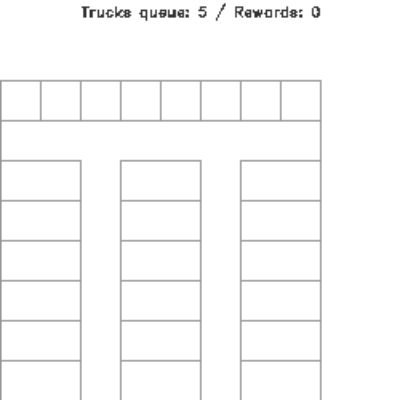

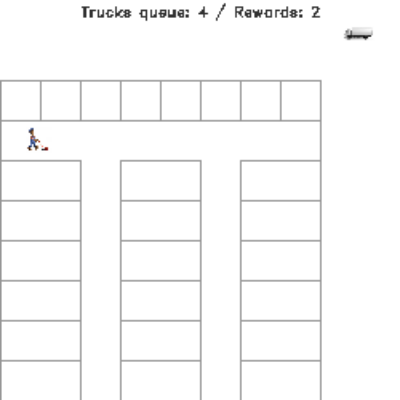

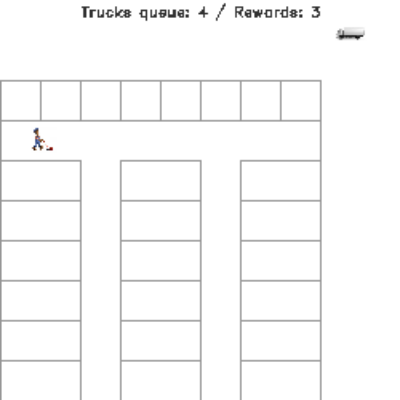

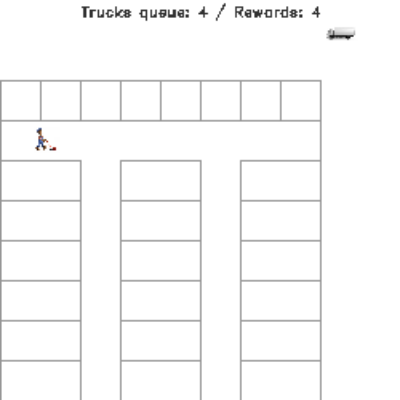

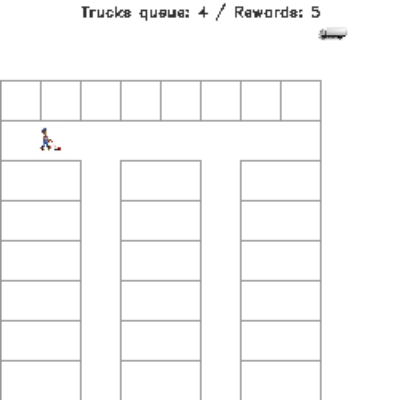

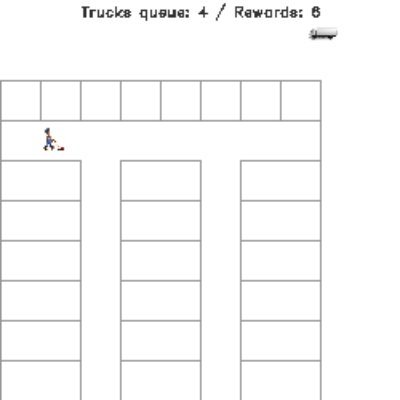

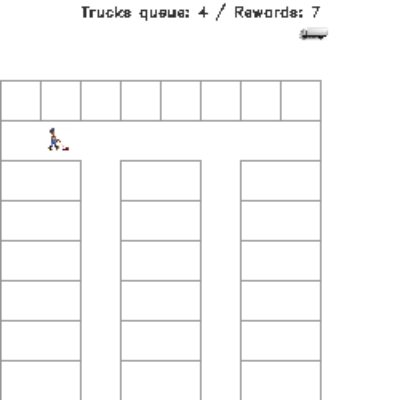

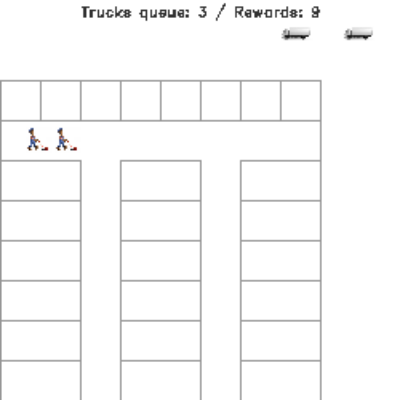

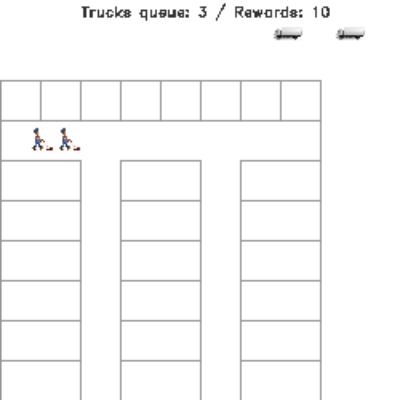

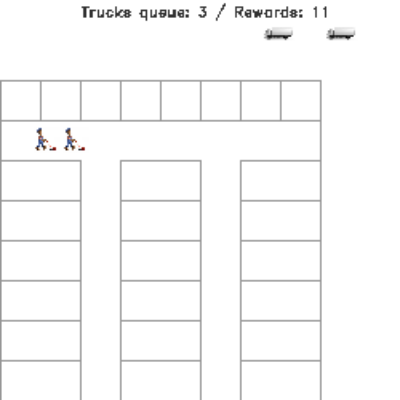

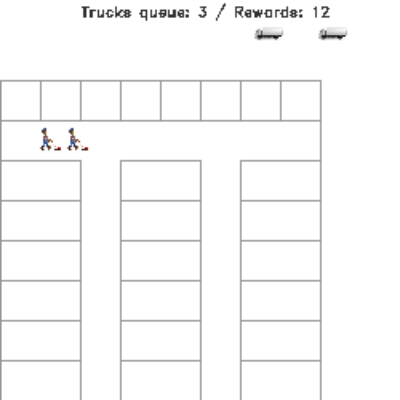

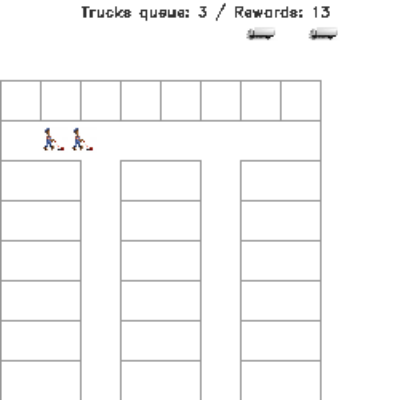

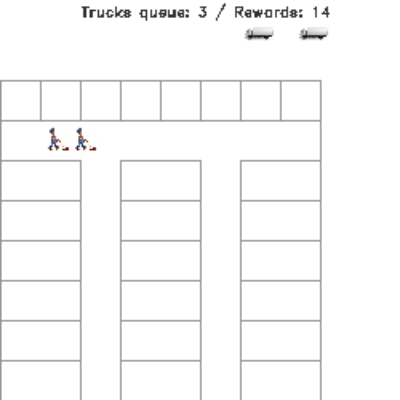

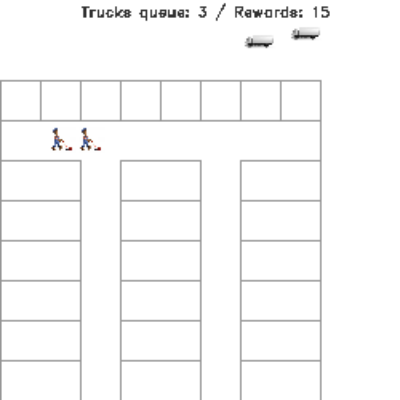

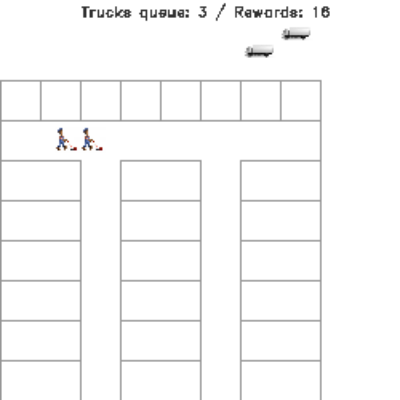

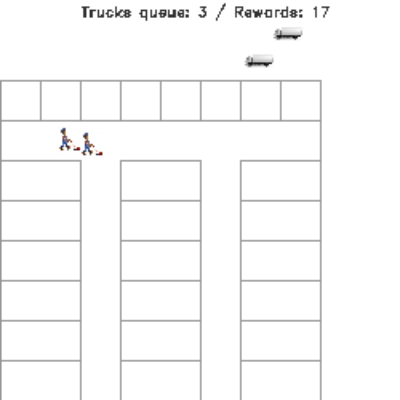

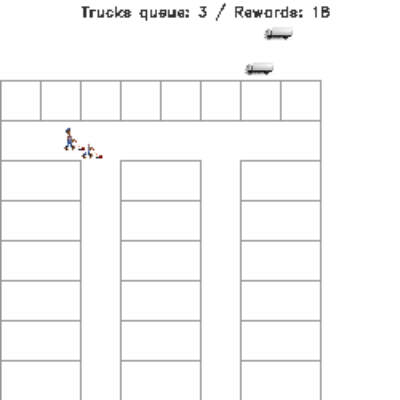

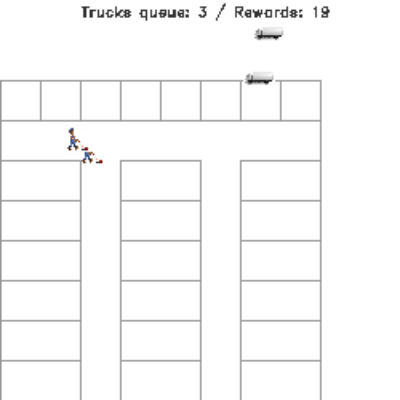

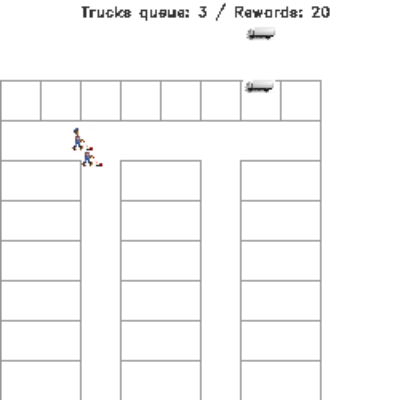

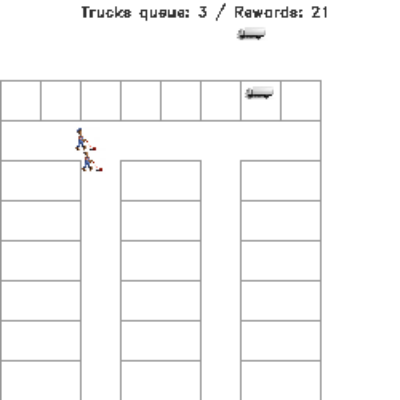

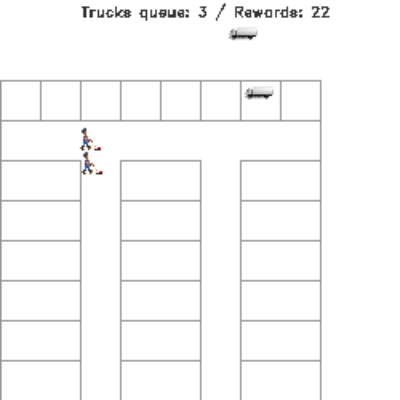

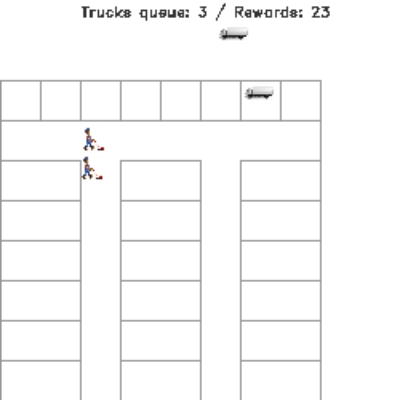

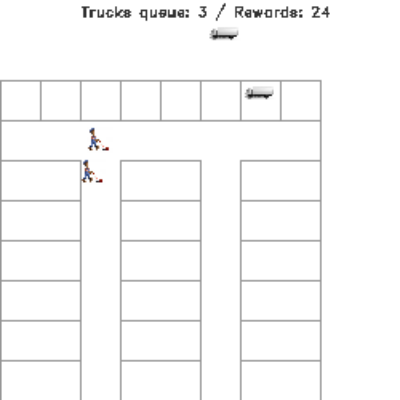

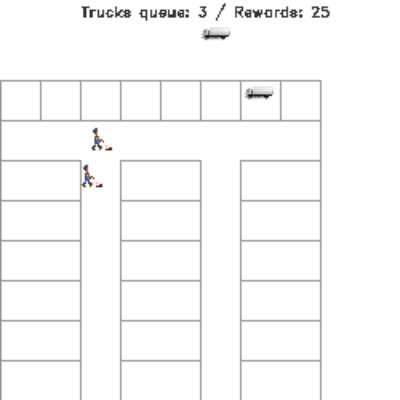

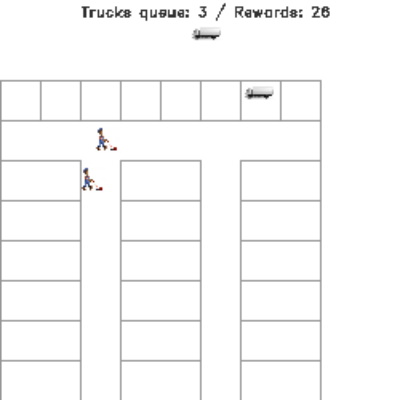

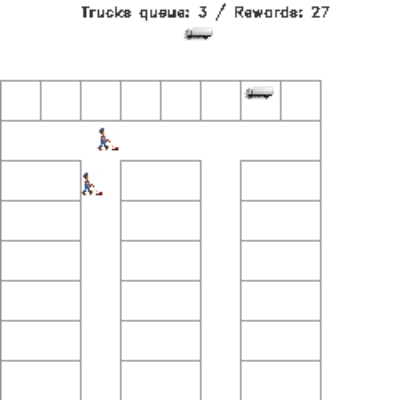

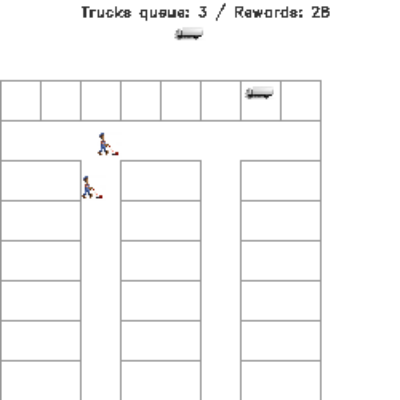

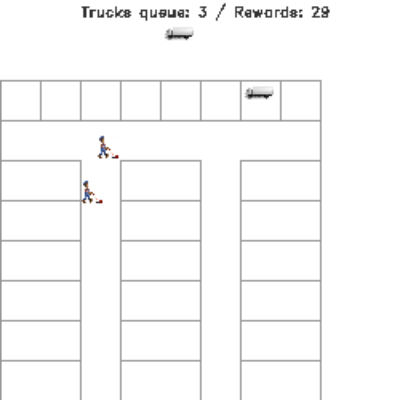

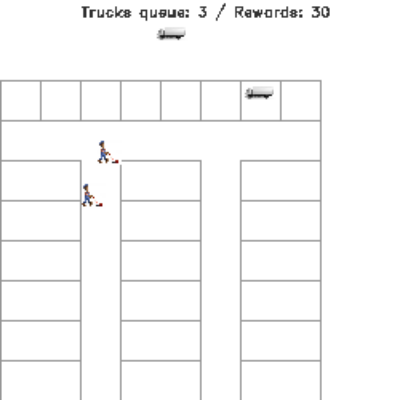

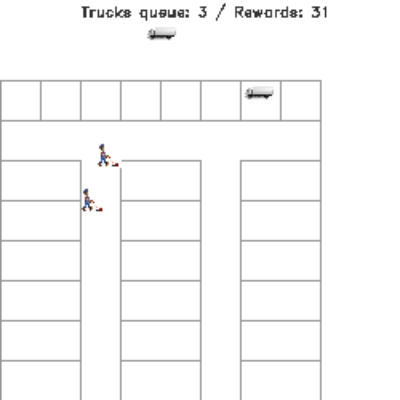

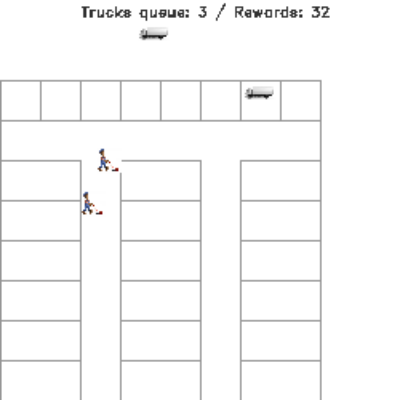

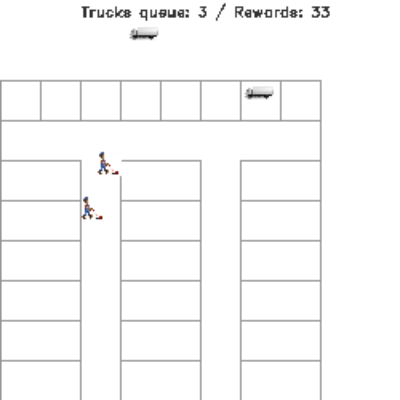

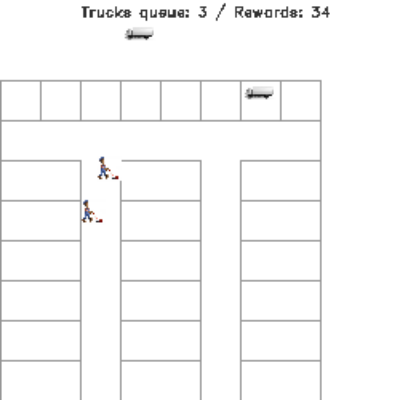

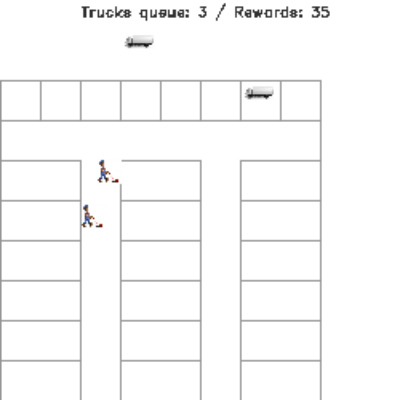

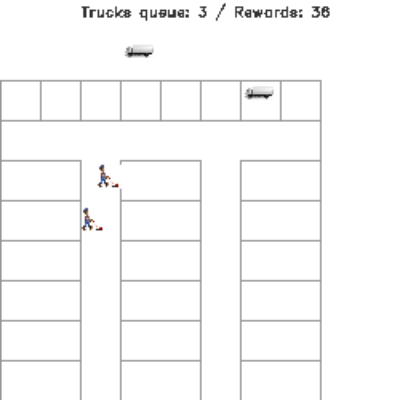

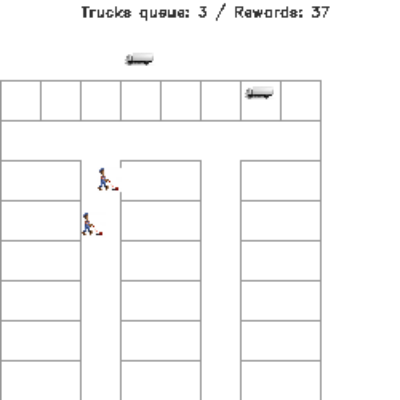

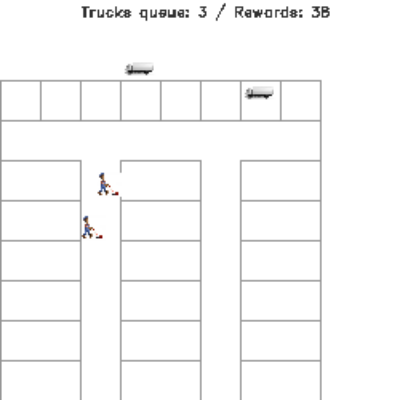

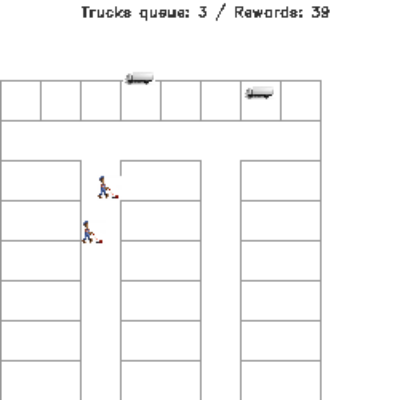

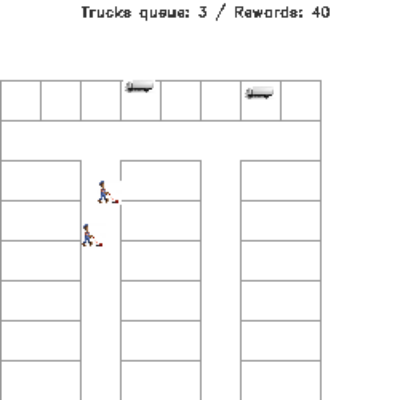

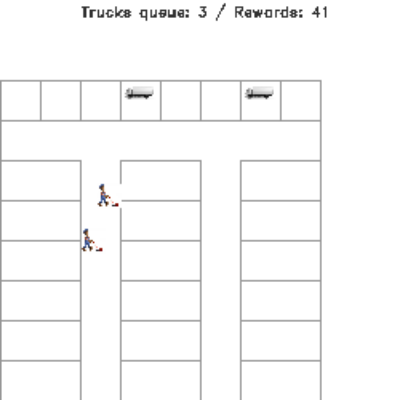

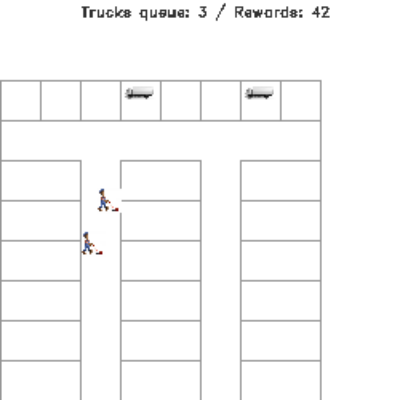

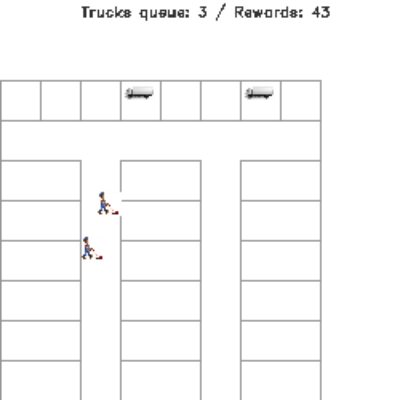

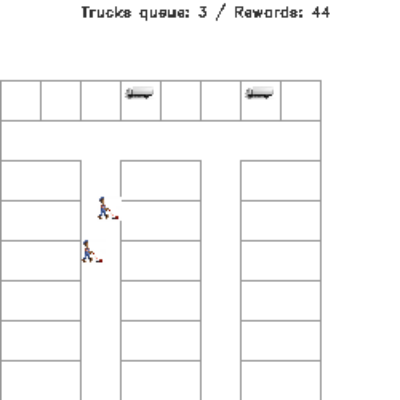

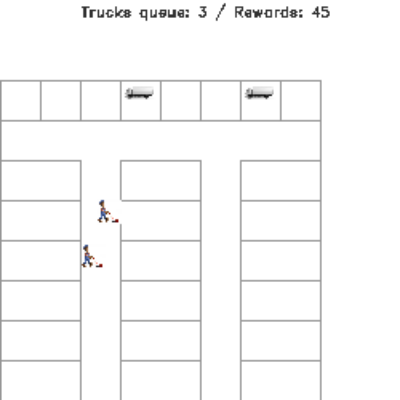

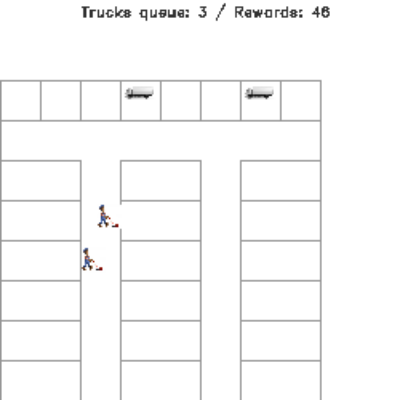

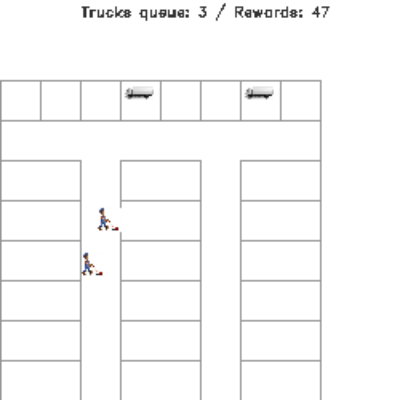

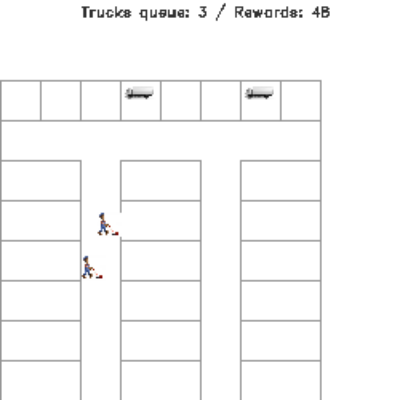

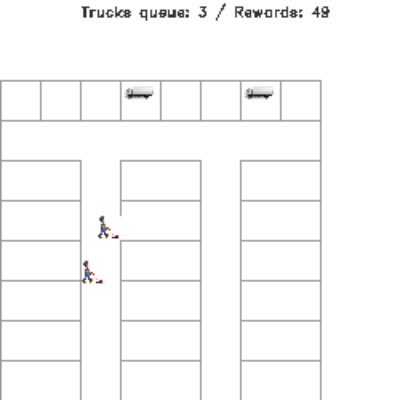

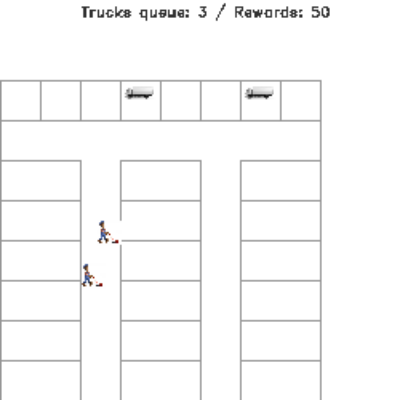

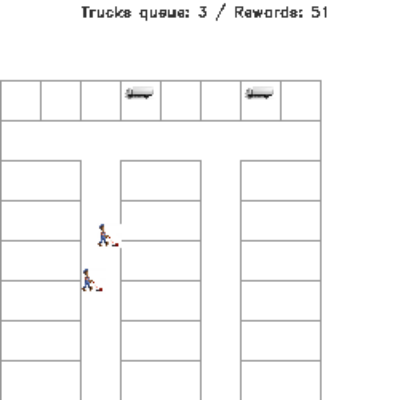

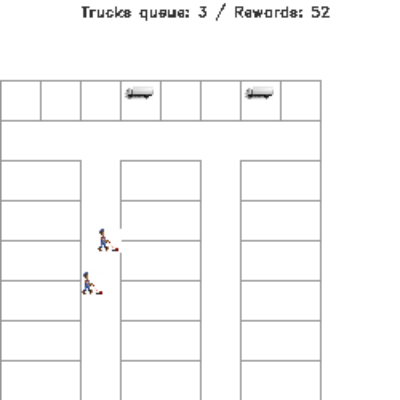

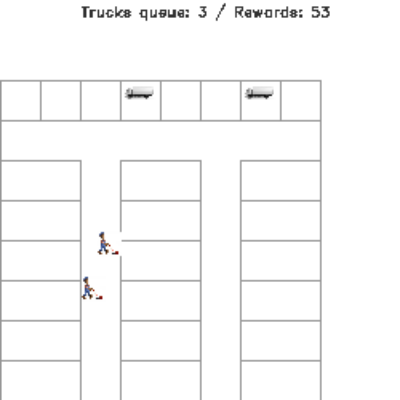

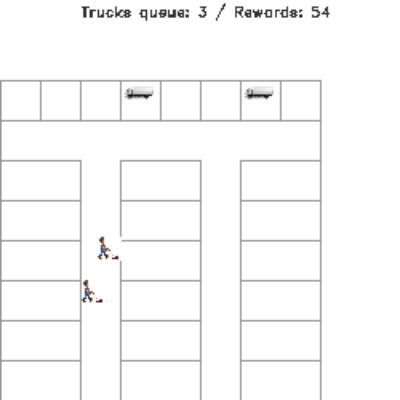

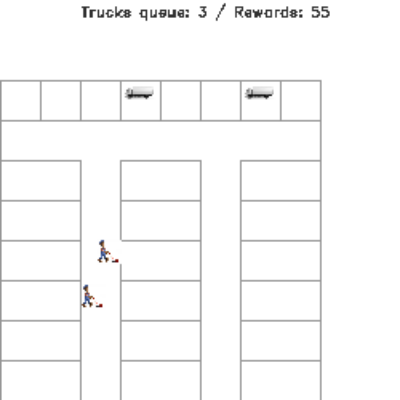

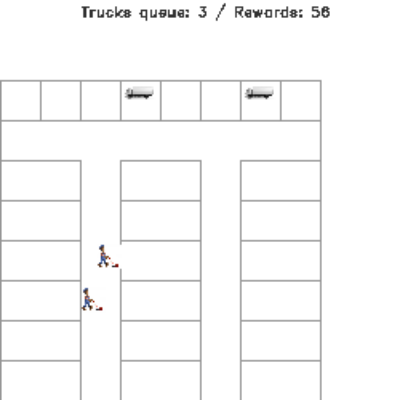

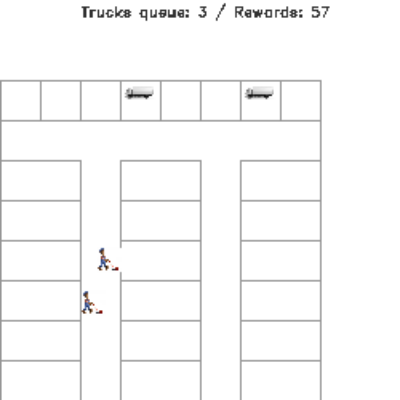

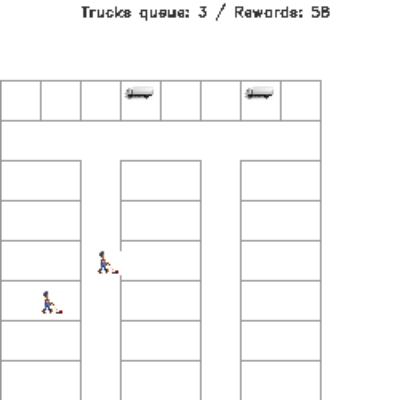

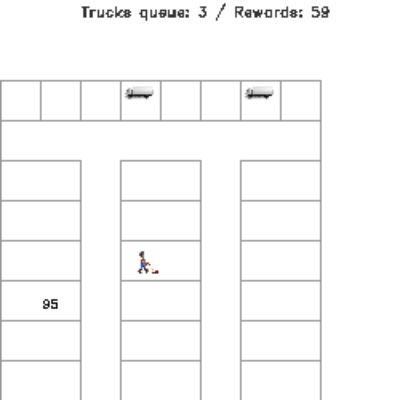

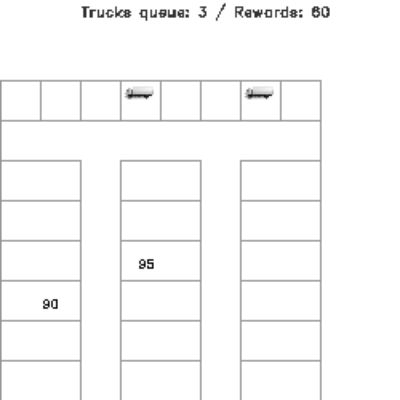

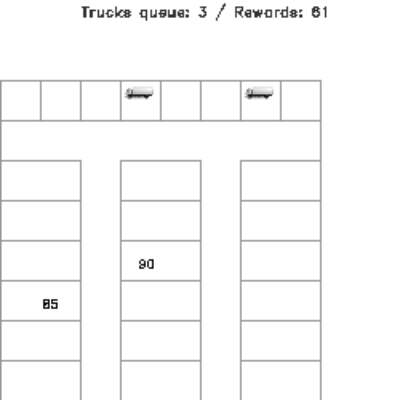

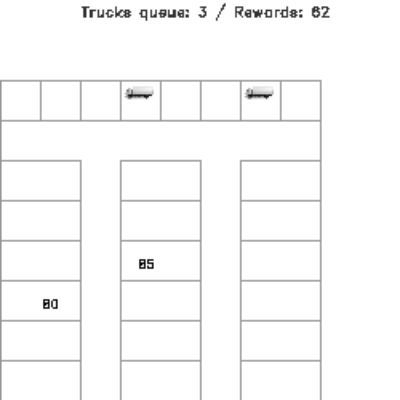

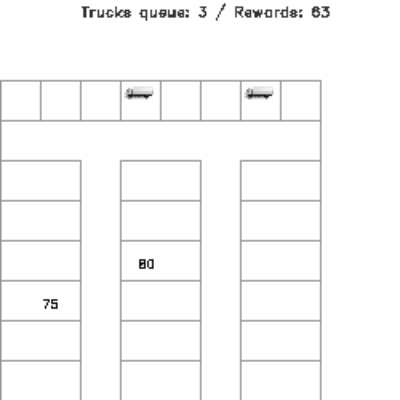

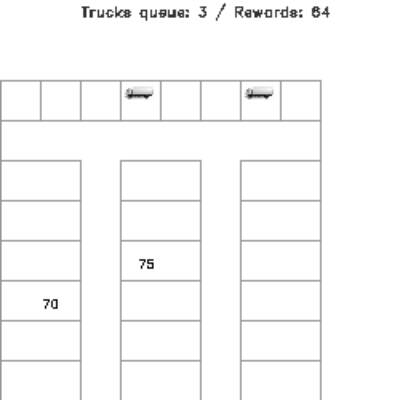

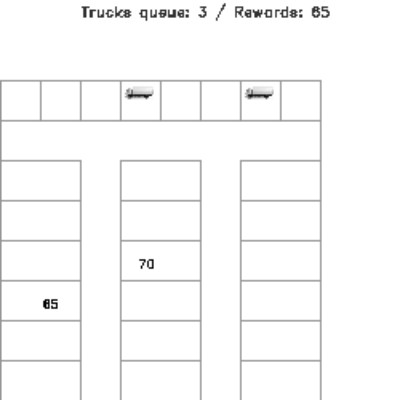

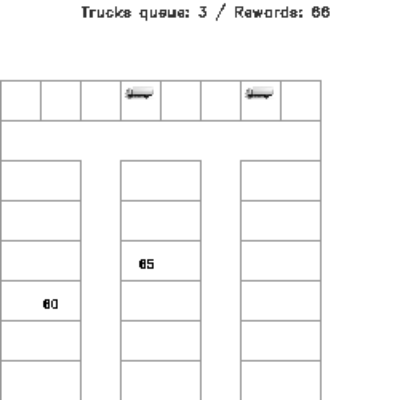

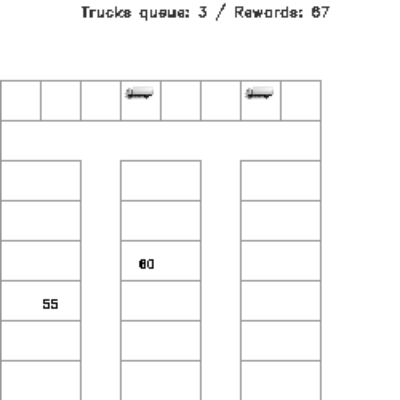

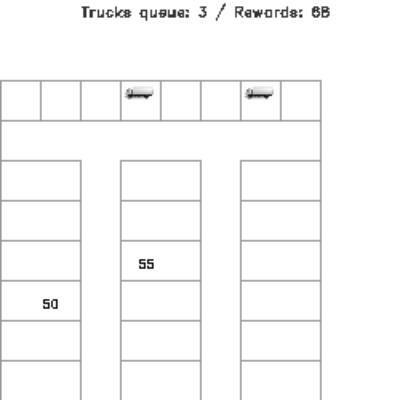

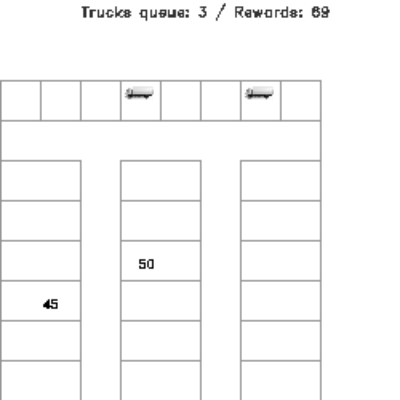

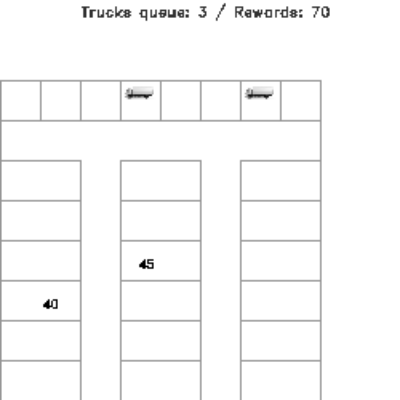

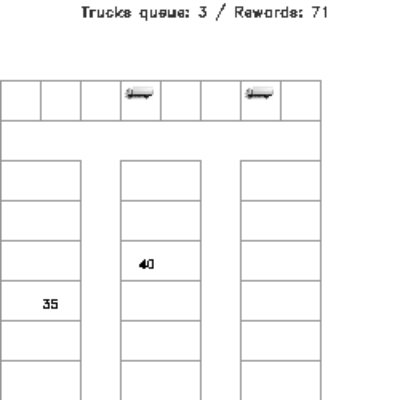

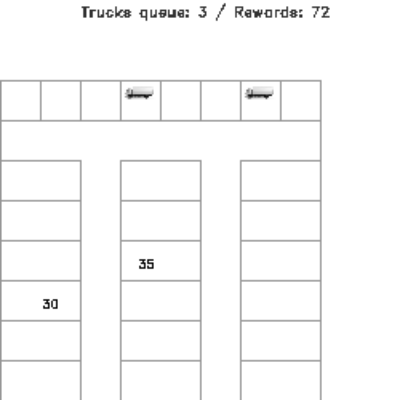

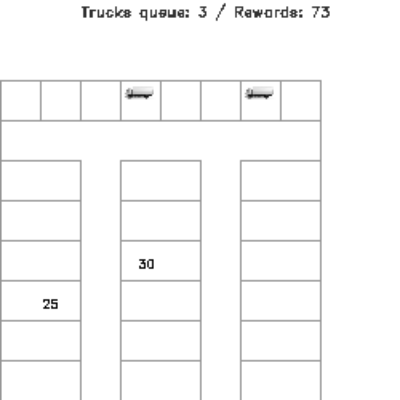

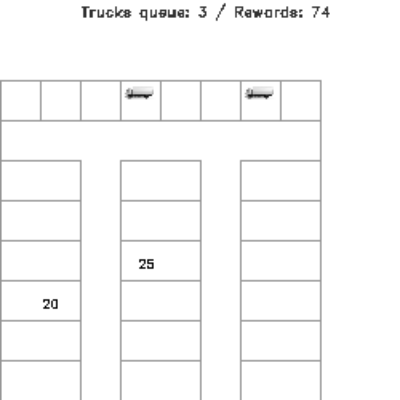

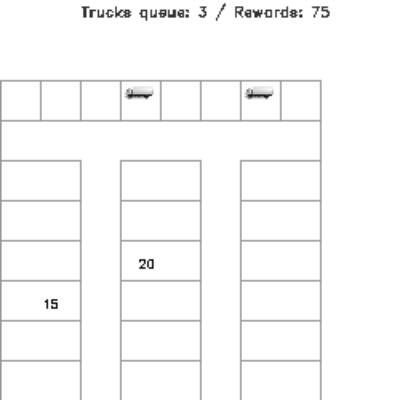

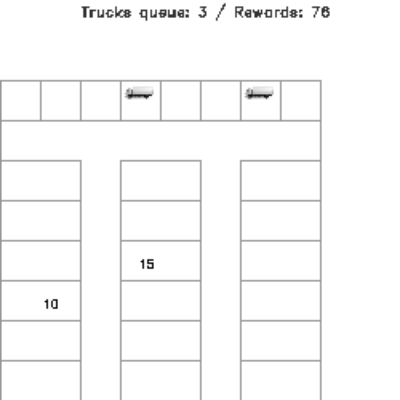

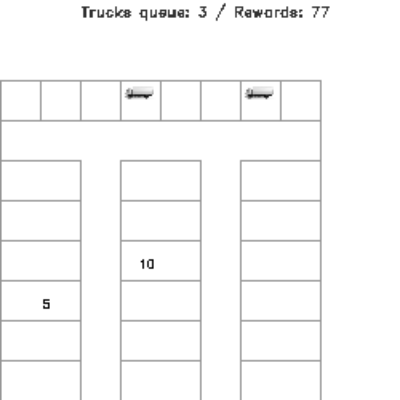

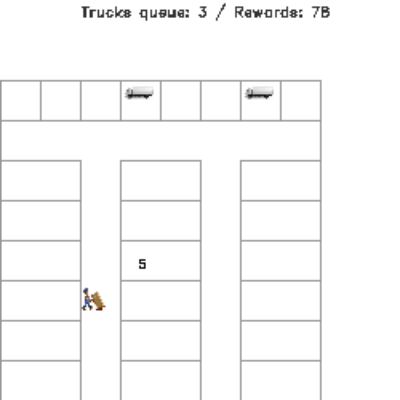

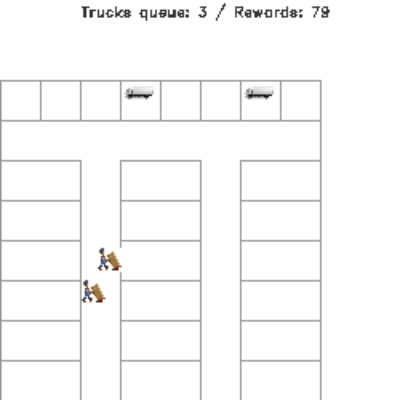

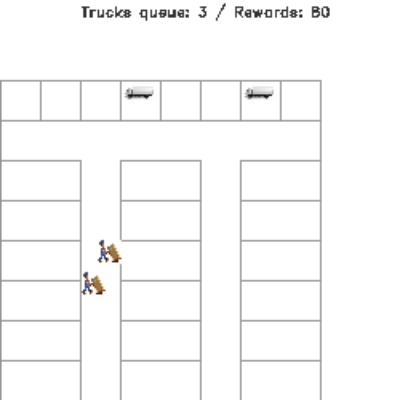

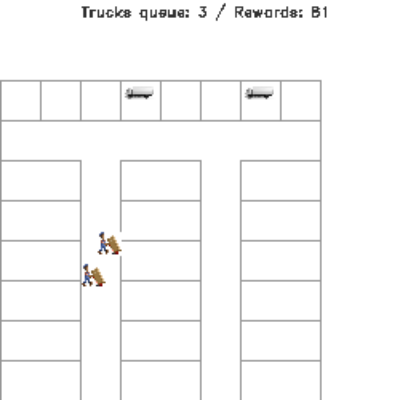

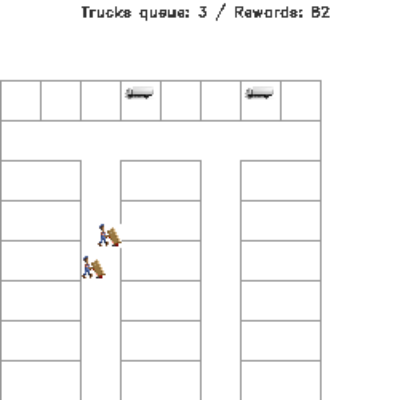

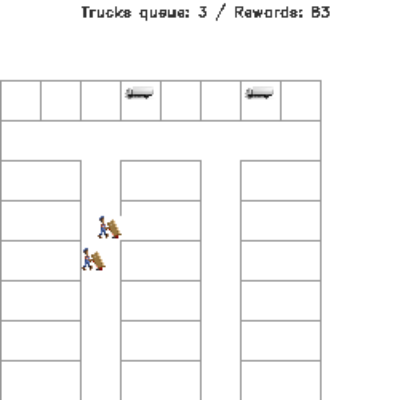

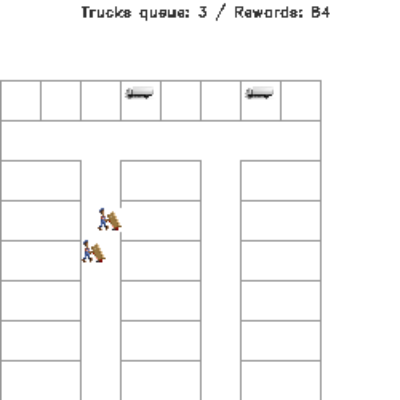

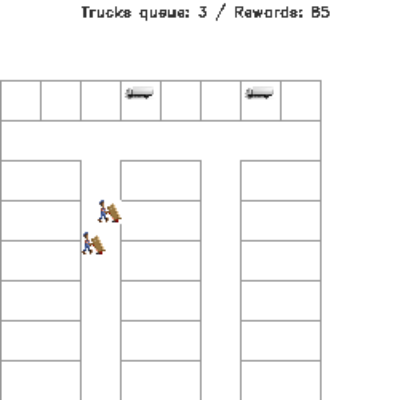

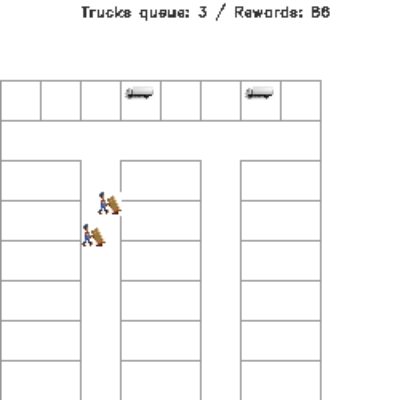

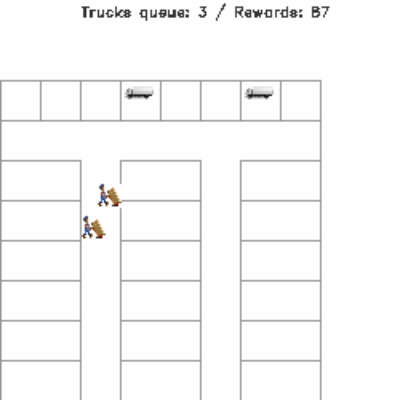

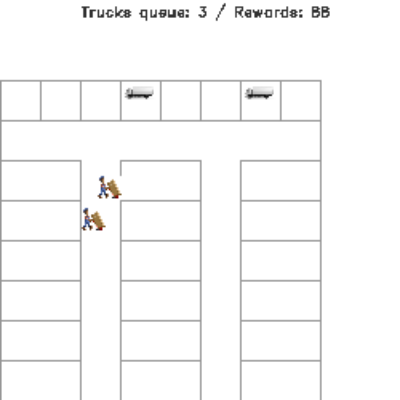

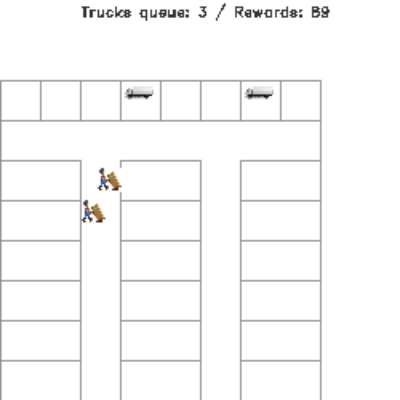

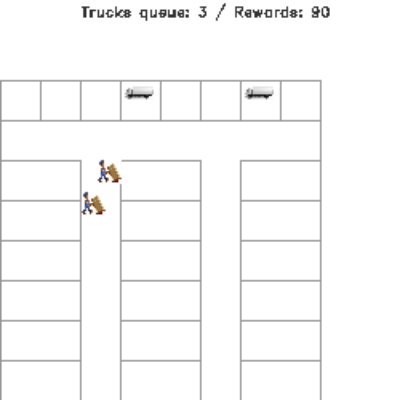

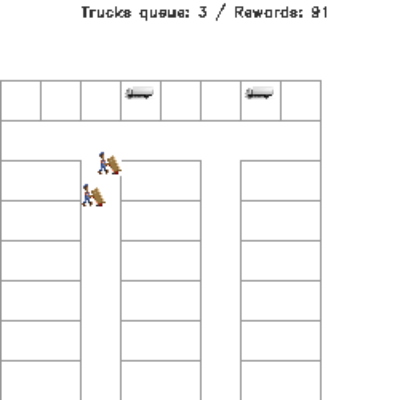

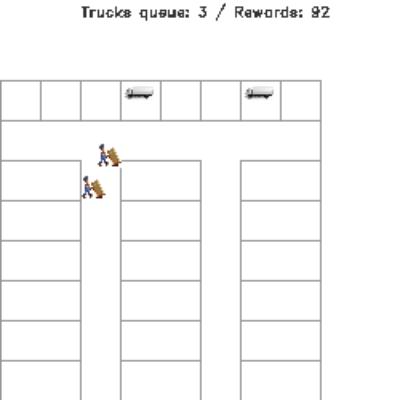

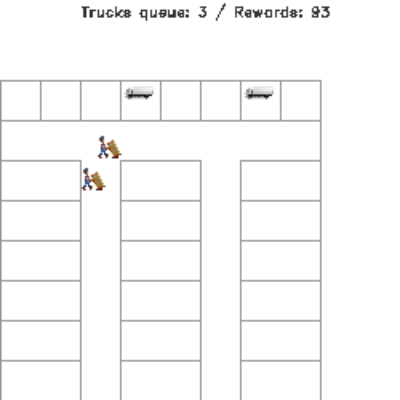

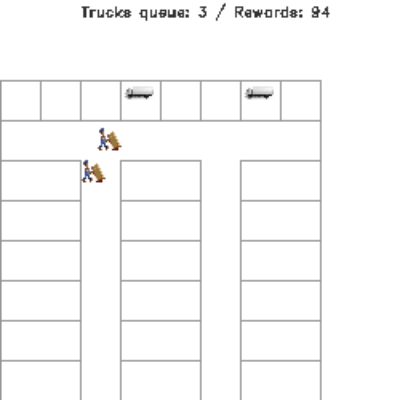

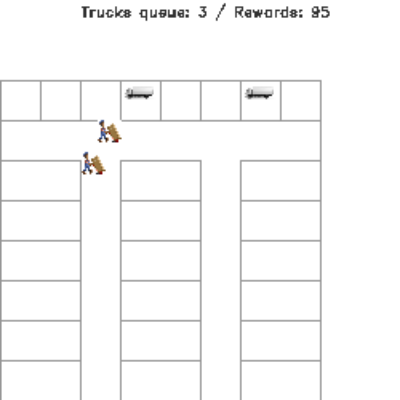

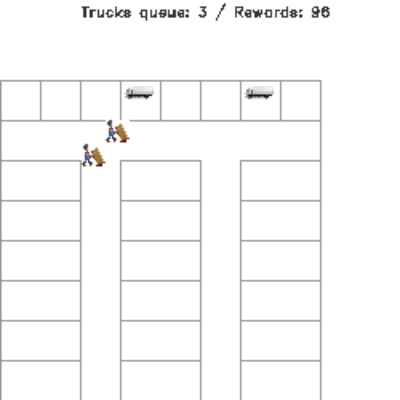

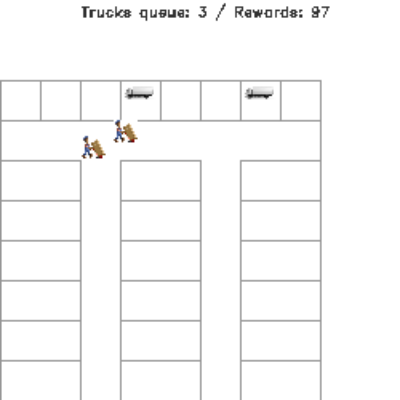

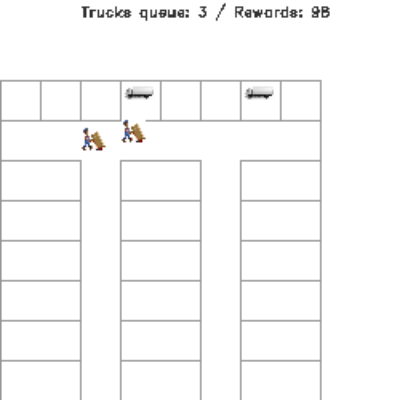

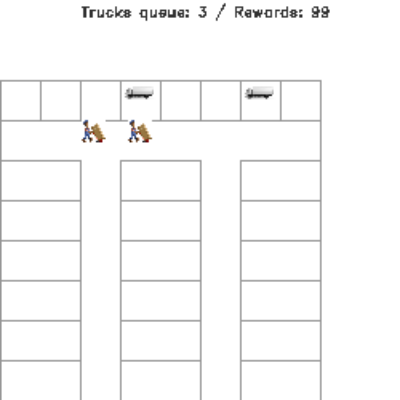

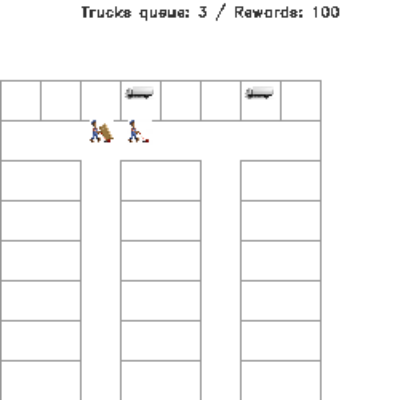

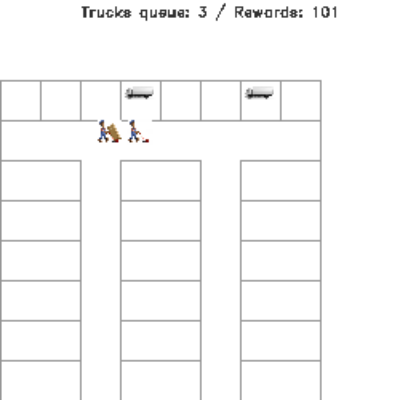

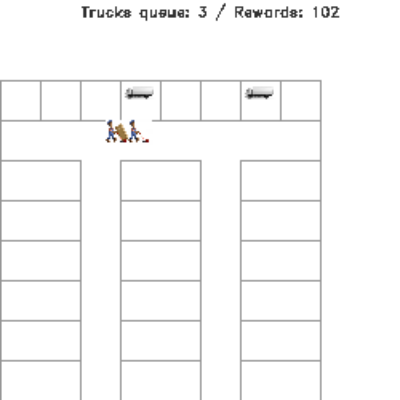

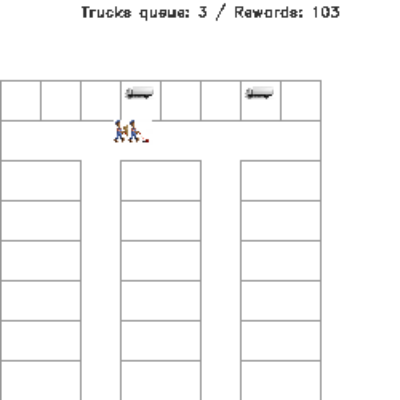

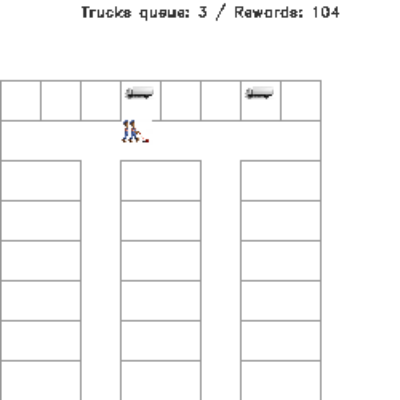

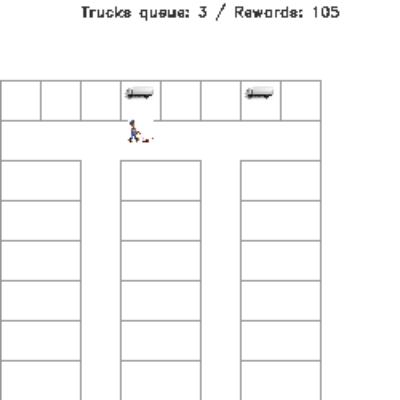

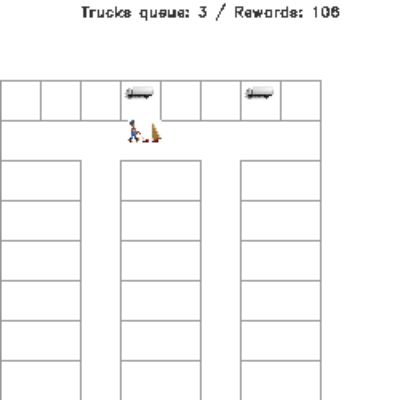

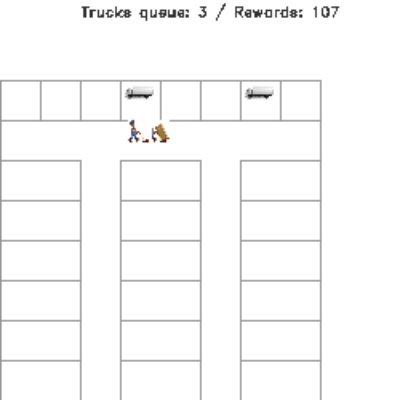

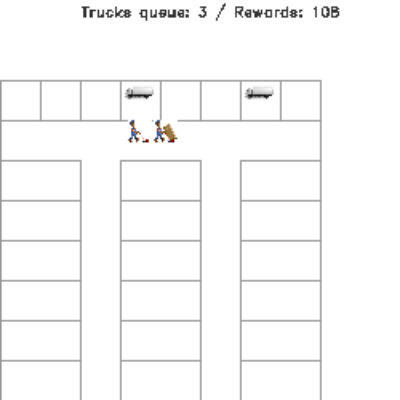

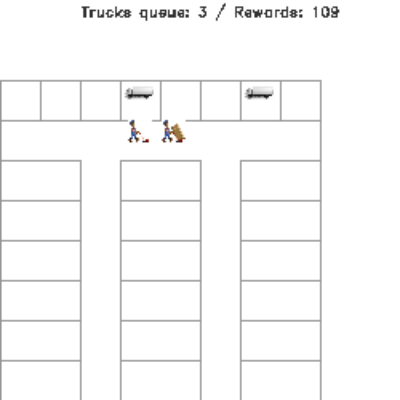

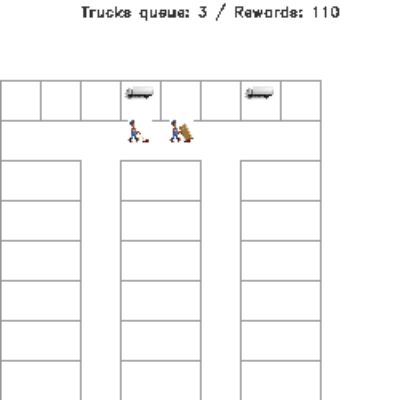

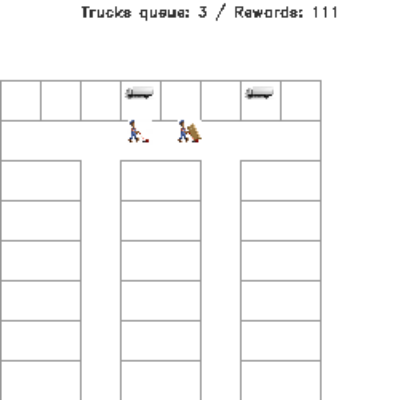

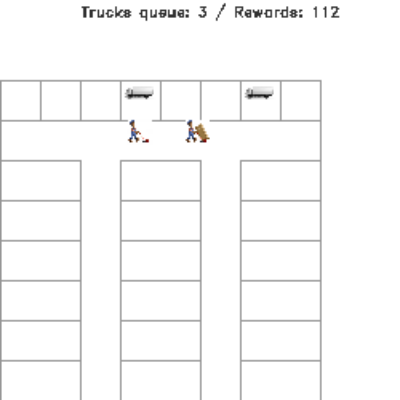

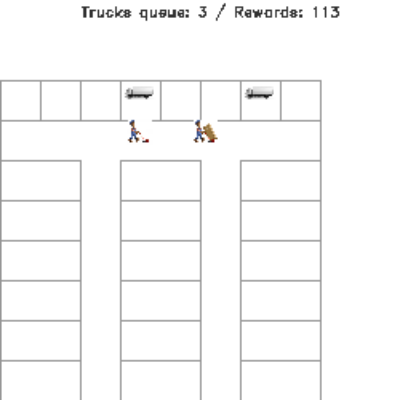

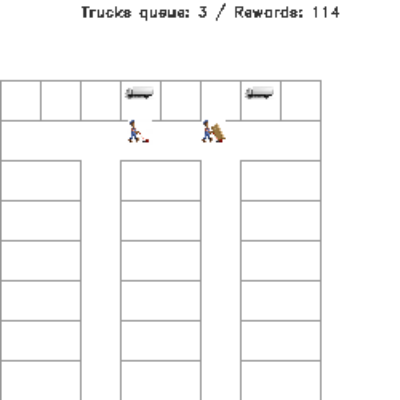

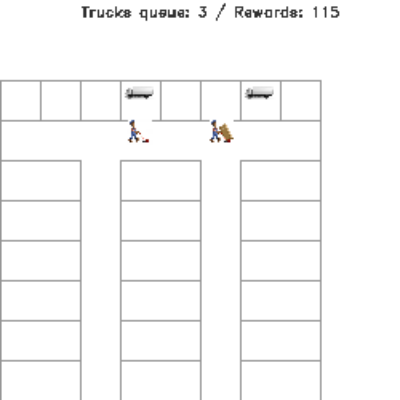

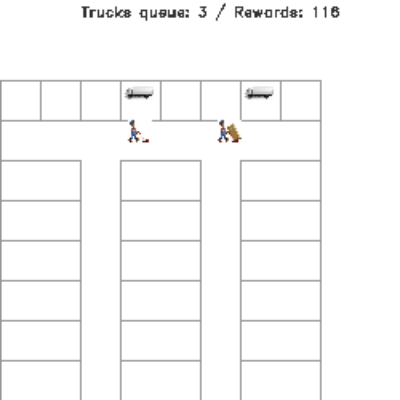

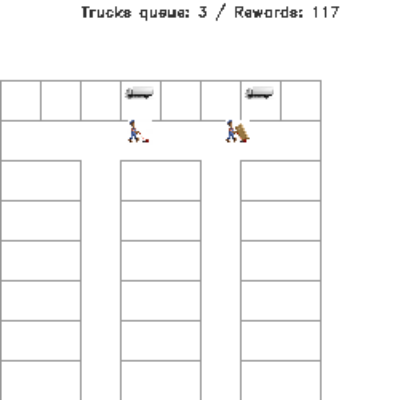

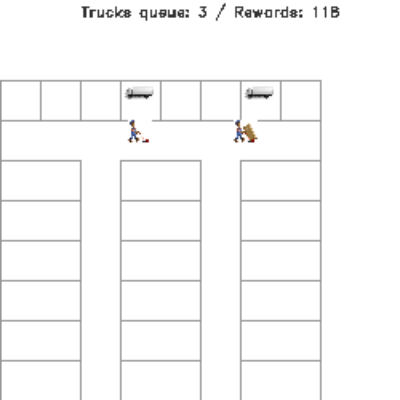

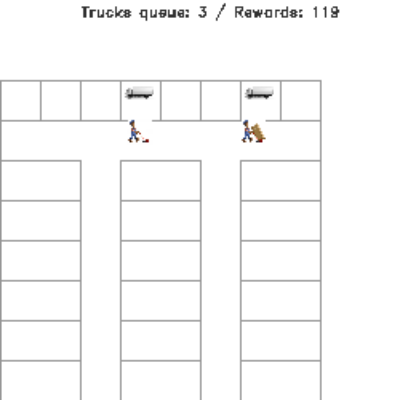

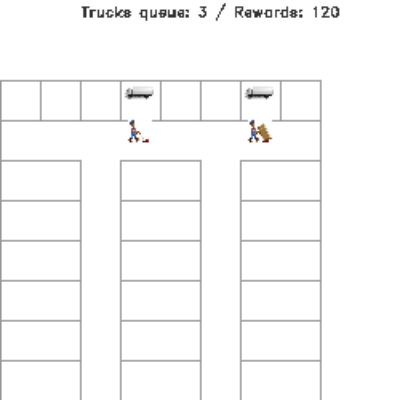

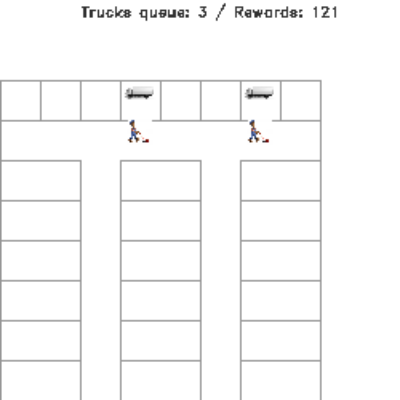

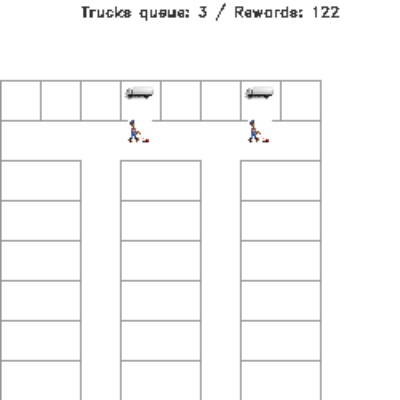

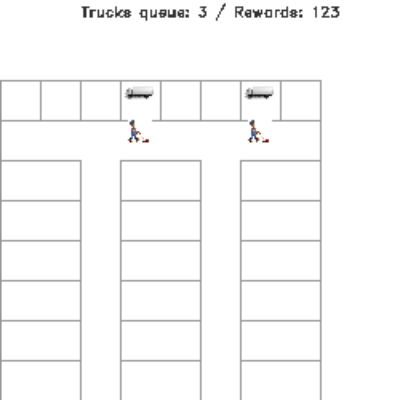

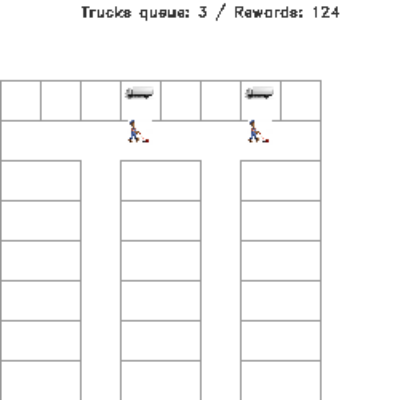

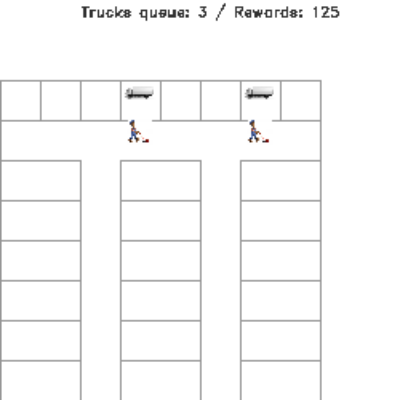

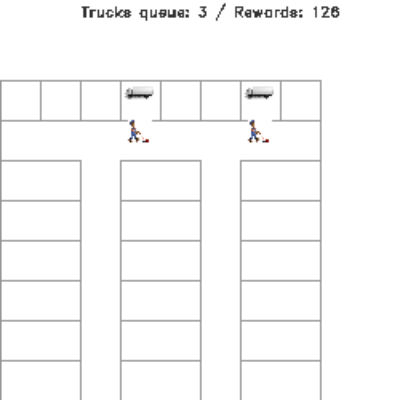

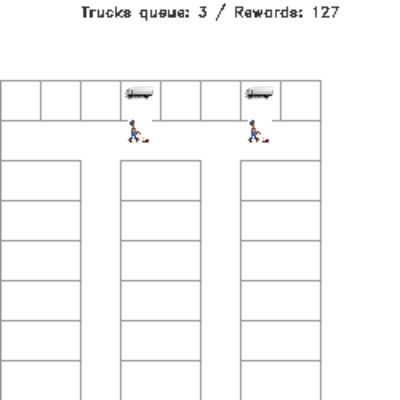

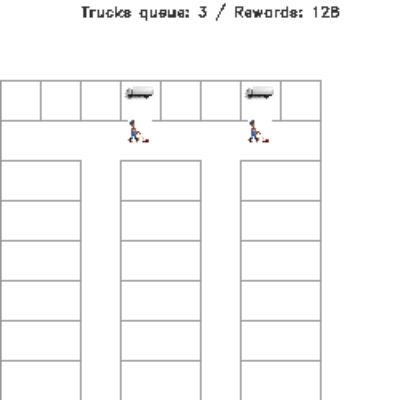

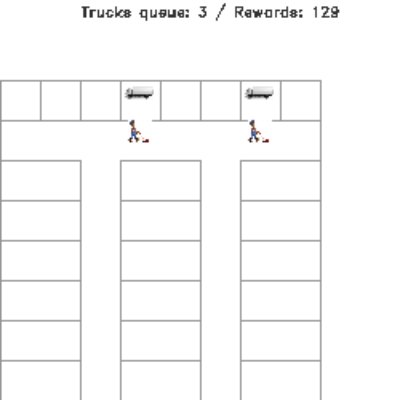

In [34]:
TRACING = False
from IPython import display
from IPython.display import clear_output

out = cv2.VideoWriter('episode.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, (400,400))

env = Depot(5,5,5)
obs = env.reset()
env.render()

obs, reward, done, info = env.step([0,0,6])         # action 0: task for truck - platform 6
obs, reward, done, info = env.step([1,3,6])         # action 1: task for mover - pallet 3 , platform 6
env.render()

im = cv2.resize((obs).astype(np.uint8), (400, 400))
out.write(im)

for i in range(5):
    env.step([3,0,0])
    env.render()

obs, reward, done, info = env.step([0,0,3])         # action 0: task for truck - platform 3
obs, reward, done, info = env.step([1,8,3])         # action 1: task for mover - pallet 8 , platform 3
env.render()

im = cv2.resize((obs).astype(np.uint8), (400, 400))
out.write(im)


for i in range(120):

    obs, reward, done, info = env.step([3,0,0])
    env.render()

    im = cv2.resize((obs).astype(np.uint8), (400, 400))
    out.write(im)

    if done == True:
        break

out.release()  
env.close()


In [35]:
!rm -rf episode.mp4
!ffmpeg -i episode.avi episode.mp4
!rm -rf episode.avi
from IPython.display import HTML
from base64 import b64encode
mp4 = open('episode.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width="800" controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li